In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Defining the R script and loading the instance in Python

r = ro.r
r['source']('baseflow_sep.R')

R[write to console]: Loading required package: operators

R[write to console]: 
Attaching package: ‘operators’


R[write to console]: The following objects are masked from ‘package:base’:

    options, strrep


R[write to console]: Loading required package: topmodel

R[write to console]: Loading required package: DEoptim

R[write to console]: Loading required package: parallel

R[write to console]: 
DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich


R[write to console]: Loading required package: XML

R[write to console]: 
Attaching package: ‘XML’


R[write to console]: The following object is masked from ‘package:tools’:

    toHTML




value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [2]:
# Loading the function we have defined in R.
baseflow_sep = ro.globalenv['get_baseflow']

# Reading and processing data
df = pd.read_csv("../data/CDEC/runoff.csv")#.set_index('date')
df.index = pd.to_datetime(df['date'])
# df = pd.DataFrame(df['SHA'], index = df.index).interpolate(how = 'linear')

# Select the column here 
with localconverter(ro.default_converter + pandas2ri.converter):
    r_pd_df = ro.conversion.py2rpy(df['SCC'])

In [3]:
# Call the R function and getting the result
runoff_df = baseflow_sep(r_pd_df)

In [4]:
# Converting it back to a pandas dataframe.
with localconverter(ro.default_converter + pandas2ri.converter):
    outdf = ro.conversion.rpy2py(runoff_df)

outdf.index = df.index
outdf.head()

,bt,qft
date,,
2003-10-01,0.005174,0.003984
2003-10-02,0.002070,0.000000
2003-10-03,0.002073,0.004137
2003-10-04,0.002078,0.002062
2003-10-05,0.002080,0.006199


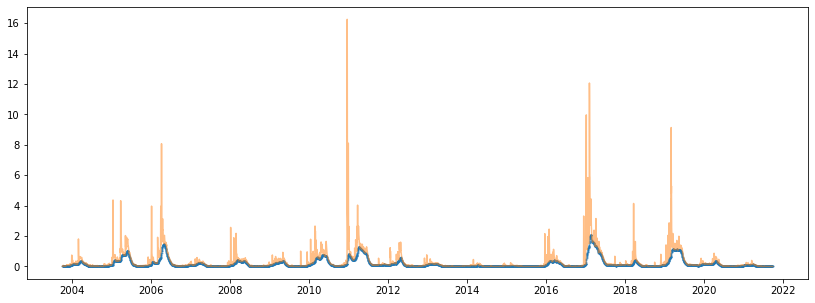

In [5]:

plt.figure(figsize =(14,5))
plt.plot(outdf.index, outdf['bt'], marker = "o", markersize = 1, alpha = 0.5)
plt.plot(outdf.index, outdf['bt'] + outdf['qft'],  markersize = 1, alpha = 0.5)